In [17]:
import os
import cv2
import glob
import random
import numpy as np
import imgaug as ia
import pandas as pd
import tensorflow as tf
from natsort import natsorted
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from skimage.transform import resize
from skimage.io import imread, imsave
from sklearn.metrics import confusion_matrix
from skimage import transform, filters, exposure
from stn import spatial_transformer_network as transformer
os.environ['CUDA_VISIBLE_DEVICES']='2'
%matplotlib inline
#http://ankivil.com/kaggle-first-steps-with-julia-chars74k-first-place-using-convolutional-neural-networks/

In [2]:
def label2int(ch):
    ascii_val = ord(ch)
    if(ascii_val <= 57): #0-9
        ascii_val -= 48
    elif(ascii_val <= 90): #A-Z
        ascii_val -= 55
    else: #a-z
        ascii_val -= 61
    return ascii_val
def int2label(i):
    if(i <= 9): #0-9
        i += 48
    elif(i<=35): #A-Z
        i += 55
    else: #a-z
        i += 61
    return chr(i)

In [18]:
#图片数据持久化，保存到本地，供下次直接调用
def data_preprocessing(data_path, img_rows=32, img_cols=32):
    if (os.path.exists(data_path + '/' + 'train_' + str(img_rows) +  '_' + str(img_cols) + '.npy') 
        and os.path.exists(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '.npy') 
        and os.path.exists(data_path + '/' + 'labels.npy')):
        print('data have already processed')
    else:
        ### Image preprocessing ###
        if not os.path.exists(data_path + "/trainResized"):
            os.makedirs(data_path + "/trainResized")
        if not os.path.exists(data_path + "/testResized"):
            os.makedirs(data_path + "/testResized")
        for set_type in ['train', 'test']:
            files = natsorted(glob.glob(data_path + '/' + set_type + '/*'))
            data = np.zeros((len(files), img_rows, img_cols))
            for i, file_path in enumerate(files):
                '''
                img = imread(file_path, as_grey=True) #读入的图为[0, 1]图
                img_resized = resize(img, (img_rows, img_cols))
                data[i] = img_resized
                #Save image
                new_name = "/".join(file_path.split("/")[:-1] ) + "Resized/" + file_path.split("/")[-1]
                imsave(new_name, img_resized)
                '''
                #利用opencv读取图片
                img = cv2.imread(file_path, 0)
                img_resized = cv2.resize(img, (img_rows, img_cols))#读入的[0, 255]的图
                data[i] = img_resized
                #Save image
                new_name = "/".join(file_path.split("/")[:-1] ) + "Resized/" + file_path.split("/")[-1]
                cv2.imwrite(new_name, img_resized)                
            #Add channel/filter dimension [222, 32, 32] => [222, 1, 32, 32]
            #train_img = np.stack(train_img)[..., None]
            data = data[:, :, :, np.newaxis]
            #data = data.astype('float32')
            #data /= 255
            np.save(data_path + '/' + set_type + '_' + str(img_rows) +  '_' + str(img_cols) + '.npy', data)
        ### Labels preprocessing ###
        y_train = pd.read_csv(data_path + '/trainLabels.csv').values[:, 1]
        #Convert one-hot vectors
        Y_train = np.zeros((y_train.shape[0], len(np.unique(y_train))))
        for i in range(y_train.shape[0]):
            Y_train[i][label2int(y_train[i])] = 1
        np.save(data_path + '/' + 'labels.npy', Y_train)
    X_train_all = np.load(data_path + '/' + 'train_' + str(img_rows) +  '_' + str(img_cols) + '.npy')
    Y_train_all = np.load(data_path + '/' + 'labels.npy')
    test_all = np.load(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '.npy')
    print('Finish')
    return X_train_all, Y_train_all, test_all

In [19]:
data_path = 'data'
X_train_all, Y_train_all, test_all = data_preprocessing(data_path, 32, 32)

Finish


(6283, 32, 32, 1) (6283, 62) (6220, 32, 32, 1)
(32, 32, 1)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
float64


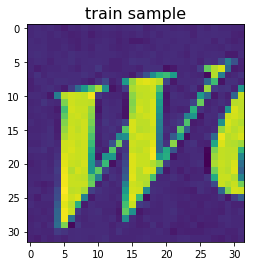

In [27]:
print(X_train_all.shape, Y_train_all.shape, test_all.shape)
sample_x = X_train_all[5]
print(X_train_all[5].shape)
print(Y_train_all[5])
plt.title('train sample', size=16)
plt.imshow(sample_x[..., 0])
print(X_train_all.dtype)

In [54]:
### 划分验证集 ###
#数据预处理 方法二
VALIDATION_SIZE = 200    #验证集大小
x_val, y_val = X_train_all[:VALIDATION_SIZE], Y_train_all[:VALIDATION_SIZE]
x_train, y_train = X_train_all[VALIDATION_SIZE:].astype('uint8'), Y_train_all[VALIDATION_SIZE:].astype('uint8')
print(x_train.shape, x_val.shape)
print(y_val[0].shape)
print(x_train[5][..., 0])

(6083, 32, 32, 1) (200, 32, 32, 1)
(62,)
[[45 46 41 ... 47 40 40]
 [44 50 58 ... 51 53 46]
 [52 67 65 ... 43 51 48]
 ...
 [46 46 43 ... 45 43 45]
 [47 43 46 ... 47 47 47]
 [50 49 44 ... 42 47 46]]


In [62]:
### Data augmentation ###
PIXELS = 32
imageSize = PIXELS * PIXELS
num_features = imageSize

# much faster than the standard skimage.transform.warp method
def fast_warp(img, tf, output_shape, mode='constant'):
    return transform._warps_cy._warp_fast(img, tf.params,output_shape=output_shape, mode=mode)
def batch_augment(data):
    x_batch_aug = data
    # random rotations betweein -10 and 10 degrees
    dorotate = np.random.randint(-10,10)

    # random translations
    trans_1 = np.random.randint(-10,10)
    trans_2 = np.random.randint(-10,10)

    # random zooms
    zoom = np.random.uniform(1, 1.3)

    # shearing
    shear_deg = np.random.uniform(-25, 25)

    # set the transform parameters for skimage.transform.warp
    # have to shift to center and then shift back after transformation otherwise
    # rotations will make image go out of frame
    center_shift   = np.array((PIXELS, PIXELS)) / 2. - 0.5
    tform_center   = transform.SimilarityTransform(translation=-center_shift)
    tform_uncenter = transform.SimilarityTransform(translation=center_shift)

    tform_aug = transform.AffineTransform(rotation = np.deg2rad(dorotate),
                                          scale =(1/zoom, 1/zoom),
                                          shear = np.deg2rad(shear_deg),
                                          translation = (trans_1, trans_2))
    tform = tform_center + tform_aug + tform_uncenter
    # images in the batch do the augmentation
    #print(x_batch_aug.shape[0])
    for j in range(x_batch_aug.shape[0]):
        #print(x_batch_aug[j][0].shape)
        x_batch_aug[j][..., 0] = fast_warp(x_batch_aug[j][..., 0], tform,
                                      output_shape = (PIXELS, PIXELS))

    # use sobel edge detector filter on one quarter of the images
    indices_sobel = np.random.choice(x_batch_aug.shape[0],
                                     x_batch_aug.shape[0] // 4, replace = False)
    for k in indices_sobel:
        img = x_batch_aug[k][0]
        x_batch_aug[k][0] = filters.sobel(img)

    # invert half of the images
    indices_invert = np.random.choice(x_batch_aug.shape[0],
                                      x_batch_aug.shape[0] // 2, replace = False)
    for l in indices_invert:
        img = x_batch_aug[l][0]
        x_batch_aug[l][0] = np.absolute(img - np.amax(img))

    return  x_batch_aug  

def batch_augment2(data):
    seq = iaa.Sequential([
        iaa.Crop(percent=0.01), # # 从每侧裁剪图像0到16px（随机选择）
        iaa.Fliplr(0.5), # 水平翻转图像 括号内为Probability of each image to get flipped.
        iaa.Flipud(0.5), #上下翻转
        #iaa.GaussianBlur(sigma=(0, 3.0)),  # 使用0到3.0的sigma模糊图像
        iaa.Affine(scale=(0.7, 1.3), translate_percent=0.01, rotate=iap.Normal(-10, 10)),#旋转
        iaa.Multiply(iap.Positive(iap.Normal(0.0, 0.1)) + 1.0),#明暗变化
        #iaa.AddElementwise(iap.Discretize((iap.Beta(0.5, 0.5) * 2 - 1.0) * 64))
        #iaa.AdditiveGaussianNoise(scale=(0,  0.05*255)),
        iaa.Sharpen(alpha=0.5),
        #iaa.Scale((0.5, 1.5))
    ],random_order=True)#每个batch中的Augmenters顺序不一样
    x_batch = seq.augment_images(data)
    return x_batch

In [8]:
### 定义STN网络 ###
#两层定位网络   
def ctn_conv(x, is_training):
    # Identity transformation
    out_size = (32, 32)
    initial = np.array([[1., 0, 0], [0, 1., 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    b_fc_loc2 = tf.Variable(initial_value=initial, name='b_fc_loc2')
    
    flatten = tf.reshape(x, [-1, 32*32*1])    
    # Frist layer
    h_fc_loc1 = tf.nn.tanh(tf.layers.dense(flatten, 20))
    if is_training == True:
        h_fc_loc1 = tf.layers.dropout(relu5, 0.25)
    # Second layer
    h_fc_loc2 = tf.nn.tanh(tf.layers.dense(h_fc_loc1, 6, use_bias=False) + b_fc_loc2)
    #h_fc_loc2 = tf.nn.tanh(tf.matmul(h_fc_loc1_drop, W_fc_loc2) + b_fc_loc2)
    h_trans = transformer(x, h_fc_loc2, out_size)
    return h_trans
def ctn_conv2(x, is_training):
    out_size = (32, 32)
    #定位特征提取网络
    with tf.variable_scope('location'):
        conv1 = tf.layers.conv2d(x, 8, 3, strides=1, padding='SAME')
        norm1 = tf.layers.batch_normalization(conv1, center=True, scale=True, training=is_training)
        relu1 = tf.nn.relu(norm1)
        pool1 = tf.layers.max_pooling2d(relu1, pool_size=[2, 2], strides=2, padding='SAME')
        
        conv2 = tf.layers.conv2d(pool1, 10, 3, strides=1, padding='SAME')
        norm2 = tf.layers.batch_normalization(conv2, center=True, scale=True, training=is_training)
        rule2 = tf.nn.relu(norm2)
        pool1 = tf.layers.max_pooling2d(rule2, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('regression'):
        flatten = tf.reshape(pool1, [-1, 8*8*10])
        fc1 = tf.layers.dense(flatten, 32)
        relu3 = tf.nn.relu(fc1)
        if is_training == True:
            relu3 = tf.layers.dropout(relu3, 0.5)
        fc2 = tf.layers.dense(relu3, 6)
    h_trans = transformer(x, fc2, out_size)
    return h_trans

In [9]:
###定义模型###
def model(x, classes, is_training):
    '''
    #stn网络，loss降不下来，反而上升，比原来效果差很多，基本不可用
    #在MNIST数据集上可用，推测STN网络应该适合应用于背景比较大的样本
    with tf.variable_scope('layer0-STN'): 
        stn = ctn_conv2(x, is_training)
    '''
    with tf.variable_scope('layer1-conv'):
        conv1 = tf.layers.conv2d(x, 128, 3, strides=1, padding='SAME')
        norm1 = tf.layers.batch_normalization(conv1, center=True, scale=True, training=is_training)
        relu1 = tf.nn.relu(norm1)
    with tf.variable_scope('layer2-conv-pool'):
        conv2 = tf.layers.conv2d(relu1, 128, 3, strides=1, padding='SAME')
        norm2 = tf.layers.batch_normalization(conv2, center=True, scale=True, training=is_training)
        relu2 = tf.nn.relu(norm2)
        pool2 = tf.layers.max_pooling2d(relu2, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer3-conv'):
        conv3 = tf.layers.conv2d(pool2, 256, 3, strides=1, padding='SAME')
        norm3 = tf.layers.batch_normalization(conv3, center=True, scale=True, training=is_training)
        relu3 = tf.nn.relu(norm3)
    with tf.variable_scope('layer4-conv-pool'):
        conv4 = tf.layers.conv2d(relu3, 256, 3, strides=1, padding='SAME')
        norm4 = tf.layers.batch_normalization(conv4, center=True, scale=True, training=is_training)
        relu4 = tf.nn.relu(norm4)
        pool4 = tf.layers.max_pooling2d(relu4, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer5-conv'):
        conv5 = tf.layers.conv2d(pool4, 512, 3, strides=1, padding='SAME')
        norm5 = tf.layers.batch_normalization(conv5, center=True, scale=True, training=is_training)
        relu5 = tf.nn.relu(norm5)
    with tf.variable_scope('layer6-conv'):
        conv6 = tf.layers.conv2d(relu5, 512, 3, strides=1, padding='SAME')
        norm6 = tf.layers.batch_normalization(conv6, center=True, scale=True, training=is_training)
        relu6 = tf.nn.relu(norm6) 
    with tf.variable_scope('layer7-conv-pool'):
        conv7 = tf.layers.conv2d(relu6, 512, 3, strides=1, padding='SAME')
        norm7 = tf.layers.batch_normalization(conv7, center=True, scale=True, training=is_training)
        relu7 = tf.nn.relu(norm7)
        pool7 = tf.layers.max_pooling2d(relu7, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer8-FC'):
        flatten = tf.reshape(pool7, [-1, 4*4*512])
        affine8 = tf.layers.dense(flatten, 4096)
        norm8 = tf.layers.batch_normalization(affine8, center=True, scale=True, training=is_training)
        relu8 = tf.nn.relu(norm8)
        if is_training == True:
            relu8 = tf.layers.dropout(relu8, 0.5)   
    with tf.variable_scope('layer9-FC'):
        affine9 = tf.layers.dense(relu8, 4096)
        norm9 = tf.layers.batch_normalization(affine9, center=True, scale=True, training=is_training)
        relu9 = tf.nn.relu(norm9)
        if is_training == True:
            relu9 = tf.layers.dropout(relu9, 0.5)
    with tf.variable_scope('layer10-FC'):
        output = tf.layers.dense(relu9, classes)
    return output

In [63]:
### 训练 ###
#训练参数
BATCH_SIZE = 128
EPOCHS = 500             #迭代次数
EARLY_STOP_PATIENCE = 100 #控制early stopping的参数

tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 32, 32, 1])
y_data = tf.placeholder(tf.float32, [None, 62])
is_training = tf.placeholder(tf.bool)
ckpt_path = './model/mode.ckpt'

predict = model(x_data, 62, is_training)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predict, labels=y_data))
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):#批归一化层
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predict, 1), tf.argmax(y_data, 1)), tf.float32))
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    best_validation_loss = 1000000.0
    current_epoch = 0
    
    epoch = EPOCHS
    batch_size = BATCH_SIZE
    train_size = len(x_train)
    train_index = list(range(train_size))
    for n in range(epoch):
        random.shuffle(train_index)  # 每个epoch都shuffle一下效果更好
        x_train_, y_train_ = x_train[train_index], y_train[train_index]
        #添加交叉验证
        #x_train, x_val, y_train, y_val = train_test_split(train_img, train_y, test_size=0.1, random_state=42, shuffle=True)
        for i in range(0, train_size, batch_size):
            x_batch = x_train_[i : i + batch_size]
            y_batch = y_train_[i : i + batch_size]
            _, loss_step = sess.run([train_step, loss], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
            #数据扩充
            x_batch_aug = batch_augment2(x_batch)
            _, loss_aug = sess.run([train_step, loss], \
                                    feed_dict={x_data:x_batch_aug, y_data:y_batch, is_training:True})
        if n % 5 == 0:
            validation_loss, accuracy = sess.run([loss, acc], feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            #validation_loss = loss.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            #accuracy = acc.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            print("epoch %d train loss is %f validataion loss is %f accuracy is %f" % (n, loss_step, validation_loss, accuracy))
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            current_epoch = n
            saver.save(sess, ckpt_path)
        elif (n - current_epoch) >= EARLY_STOP_PATIENCE:
            print('early stoping')
            break  

epoch 0 train loss is 3.897062 validataion loss is 4.230770 accuracy is 0.160000
epoch 5 train loss is 0.847832 validataion loss is 1.897475 accuracy is 0.640000
epoch 10 train loss is 0.373312 validataion loss is 1.512475 accuracy is 0.680000
epoch 15 train loss is 0.307937 validataion loss is 1.271813 accuracy is 0.740000
epoch 20 train loss is 0.150713 validataion loss is 1.234398 accuracy is 0.750000
epoch 25 train loss is 0.099768 validataion loss is 1.664895 accuracy is 0.765000
epoch 30 train loss is 0.038349 validataion loss is 1.232800 accuracy is 0.735000
epoch 35 train loss is 0.087021 validataion loss is 1.263785 accuracy is 0.770000
epoch 40 train loss is 0.049804 validataion loss is 1.232045 accuracy is 0.750000
epoch 45 train loss is 0.014133 validataion loss is 1.384455 accuracy is 0.745000
epoch 50 train loss is 0.015281 validataion loss is 1.144700 accuracy is 0.805000
epoch 55 train loss is 0.055982 validataion loss is 1.254721 accuracy is 0.745000
epoch 60 train los

In [17]:
### 计算混淆矩阵  ###
def testModel(ckpt_path):
    tf.reset_default_graph()#mo
    x_data = tf.placeholder(tf.float32, [None, 32, 32, 1])
    y_data = tf.placeholder(tf.float32, [None, 62])
    is_training = tf.placeholder(tf.bool)
    out = model(x_data, 62, is_training)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, 1), tf.argmax(y_data, 1)), tf.float32))
    saver = tf.train.Saver() 
    with tf.Session() as sess:
        saver.restore(sess, ckpt_path)
        #sess.run(out, feed_dict={x_data:x_val, y_data:y_val, is_training:False})
        y_hat = out.eval({x_data: x_val, is_training:False})
        y_pred = np.argmax(y_hat, axis=1)
        y_true = np.argmax(y_val, axis=1)
        cm = confusion_matrix(y_true, y_pred)
        '''
        for i in range(cm.shape[0]):# 混淆矩阵
            for j in range(cm.shape[1]):
                print(cm[i][j], end=' ')
            print('\n')
        '''
        print(cm)
        acc = accuracy.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
        print(acc)

In [26]:
ckpt_path = "./model/mode.ckpt"
testModel(ckpt_path)

INFO:tensorflow:Restoring parameters from ./model/mode.ckpt
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.735


In [11]:
### Submit ###
def submit(model_save_path, output_file):
    tf.reset_default_graph()
    x_test_data = tf.placeholder(tf.float32, [None, 32, 32, 1])
    is_training = tf.placeholder(tf.bool)
    logits = model(x_test_data, 62, is_training)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, model_save_path)
        
        y_pred = []
        test_size = len(test_all)
        batch_size = 1
        for i in range(0, test_size, batch_size):
            x_test_batch = test_all[i*batch_size : (i+1)*batch_size]
            y_hat = logits.eval({x_test_data: x_test_batch, is_training:False})
            y_pred_batch = np.argmax(y_hat, axis=1)
            #vInt2label = np.vectorize(int2label)
            y_pred.append(int2label(y_pred_batch))      
        with open(output_file, 'w') as f:
            f.write('ID,Class\n')
            for i in range(len(y_pred)):
                f.write("".join([str(i+6284), ',', y_pred[i], '\n']))
        print('Finish!')

In [12]:
model_save_path = "./model/mode.ckpt"
output_file = "submission.csv"
submit(model_save_path, output_file)

INFO:tensorflow:Restoring parameters from ./model/mode.ckpt
Finish!
